# LSTM

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [10]:
# import pandas as pd
# from datetime import datetime
# from pykrx import stock
# import os

# now = datetime.now()
# today_date1 = '20240430'
# start_date = '20200101'

# market_list = ['KOSPI']

# # 모든 ticker 정보 수집
# kor_ticker_list_df = pd.DataFrame()
# for market_nm in market_list:
#     ticker_list = stock.get_market_ticker_list(today_date1, market=market_nm)
#     for ticker in ticker_list:
#         corp_name = stock.get_market_ticker_name(ticker)
#         kor_ticker_list_df = kor_ticker_list_df.append({'ticker': ticker,
#                                                         'corp_name': corp_name,
#                                                         'market': market_nm}, ignore_index=True)

# # OHLCV 데이터를 모두 하나의 DataFrame에 저장
# all_ohlcv = pd.DataFrame()
# for ticker in kor_ticker_list_df['ticker']:
#     try:
#         df_raw = stock.get_market_ohlcv(start_date, today_date1, ticker)
#         df_raw.reset_index(inplace=True)
#         df_raw['ticker'] = ticker
#         all_ohlcv = pd.concat([all_ohlcv, df_raw], ignore_index=True)
#         print(f'{ticker} success')
#     except Exception as e:
#         print(f'{ticker} fail - {str(e)}')

# # 최종 데이터 저장
# if not os.path.exists('data_crawler'):
#     os.makedirs('data_crawler')

# all_ohlcv.to_csv('/aiffel/aiffel/fnguide/KOSPI(2020~2024).csv', index=False)
# print('All data saved successfully.')


095570 success
006840 success
027410 success
282330 success
138930 success
001460 success
001465 success
001040 success
079160 success
00104K success
000120 success
011150 success
011155 success
001045 success
097950 success
097955 success
000480 success
000590 success
012030 success
016610 success
005830 success
000990 success
139130 success
001530 success
000210 success
000215 success
375500 success
37550L success
37550K success
007340 success
004840 success
155660 success
069730 success
017860 success
017940 success
365550 success
383220 success
007700 success
114090 success
078930 success
006360 success
001250 success
007070 success
078935 success
012630 success
039570 success
089470 success
294870 success
009540 success
267250 success
267270 success
010620 success
322000 success
042670 success
267260 success
329180 success
097230 success
014790 success
003580 success
204320 success
060980 success
011200 success
035000 success
003560 success
175330 success
234080 success
001060 suc

In [4]:
# 파일 경로
file_path = '/aiffel/aiffel/fnguide/KOSPI(2020~2024).csv'

# CSV 파일 불러오기

df = pd.read_csv(file_path)

# 'ticker' 열의 값을 문자열로 변환하고, 5자리인 경우 앞에 '0'을 추가
df['ticker'] = df['ticker'].astype(str).str.zfill(6)

# 변경된 데이터 확인
print(df.head(30))

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


            날짜    시가    고가    저가    종가     거래량       등락률  ticker
0   2020-01-02  4900  5140  4895  5050  210107  1.609658  095570
1   2020-01-03  5050  5150  5030  5100  128274  0.990099  095570
2   2020-01-06  5080  5080  4950  5030  162087 -1.372549  095570
3   2020-01-07  5030  5100  4965  5030   42008  0.000000  095570
4   2020-01-08  5050  5060  4735  4935  110827 -1.888668  095570
5   2020-01-09  4970  5150  4860  4960   21867  0.506586  095570
6   2020-01-10  5000  5000  4920  4940   26952 -0.403226  095570
7   2020-01-13  4985  4985  4820  4860   48082 -1.619433  095570
8   2020-01-14  4895  4940  4790  4860   70557  0.000000  095570
9   2020-01-15  4890  4950  4805  4880   27356  0.411523  095570
10  2020-01-16  4895  4995  4830  4950   40317  1.434426  095570
11  2020-01-17  5070  5100  4785  4875  142862 -1.515152  095570
12  2020-01-20  4805  4830  4670  4740  126487 -2.769231  095570
13  2020-01-21  4740  4895  4700  4850   96455  2.320675  095570
14  2020-01-22  4825  491

In [5]:
df = df[df['ticker'] == '005930']

In [6]:
df.shape

(1069, 8)

In [7]:
# 날짜 포맷 확인 및 변환
df['날짜'] = pd.to_datetime(df['날짜'])

In [8]:
# 스케일링
columns_to_scale = ['시가', '고가', '저가', '종가', '거래량']

# StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 스케일링 실행
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [47]:
# 시퀀스 데이터와 레이블 생성 함수
def create_sequences_and_labels(df, sequence_length, threshold=5, look_forward=30):
    sequences = []
    labels = []
    
    if len(df) >= sequence_length + look_forward:
        for i in range(len(df) - sequence_length - look_forward + 1):
            sequence_start = i
            sequence_end = i + sequence_length
            future_start = sequence_end
            future_end = future_start + look_forward

            sequences.append(df[['시가', '고가', '저가', '종가', '거래량']].iloc[sequence_start:sequence_end].values)
            future_data = df.iloc[future_start:future_end]
            labels.append(any(future_data['등락률'] >= threshold))

        return np.array(sequences), np.array(labels).astype(int)
    else:
        return np.array([]), np.array([])  # 데이터 포인트가 부족할 경우 빈 배열 반환

# 시퀀스 길이 설정
sequence_length = 180  # 과거 365일의 데이터로 시퀀스 생성
num_features = 5

# 단일 종목에 대한 시퀀스와 레이블 생성
sequences, labels = create_sequences_and_labels(df, sequence_length)

if sequences_and_labels[0].size > 0:
    print(f"Sequences Shape: {sequences_and_labels[0].shape}")
    print(f"Labels Shape: {sequences_and_labels[1].shape}")
else:
    print("No sequences available")

Sequences Shape: (860, 180, 5)
Labels Shape: (860,)


In [48]:
# Assuming the sequences and labels are generated by the function above
sequences, labels = create_sequences_and_labels(df, sequence_length)

# Check if sequences were successfully created
if sequences.size > 0:
    print(f"Sequences Shape: {sequences.shape}")
    print(f"Labels Shape: {labels.shape}")
    
    # Calculate the total number of labels
    total_samples = len(labels)
    
    # Calculate the number of positive samples
    positive_samples = np.sum(labels)
    
    # Calculate the target ratio of positive samples
    target_ratio = positive_samples / total_samples
    
    print(f"Total samples: {total_samples}")
    print(f"Positive samples: {positive_samples}")
    print(f"Target ratio: {target_ratio:.2f}")  # Display the ratio as a percentage
else:
    print("No sequences available")

Sequences Shape: (860, 180, 5)
Labels Shape: (860,)
Total samples: 860
Positive samples: 127
Target ratio: 0.15


In [49]:
# LSTM 모델
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [50]:
# F1 Score 콜백 정의
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.X_val) > 0.5).astype(int)
        val_targ = self.y_val
        precision = precision_score(val_targ, val_predict, zero_division=0)
        recall = recall_score(val_targ, val_predict, zero_division=0)
        f1 = f1_score(val_targ, val_predict, zero_division=0)

        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

    def plot_metrics(self):
        epochs = range(1, len(self.f1_scores) + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, self.f1_scores, label='F1 Score')
        plt.plot(epochs, self.precision_scores, label='Precision')
        plt.plot(epochs, self.recall_scores, label='Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        plt.title('Model Performance Metrics')
        plt.grid(True)
        plt.show()

In [55]:
# 데이터 분할 후 인덱스 리셋
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    sequences, labels, np.arange(sequences.shape[0]), test_size=0.2, random_state=42)

# 데이터프레임 인덱스 리셋
df = df.reset_index(drop=True)


# 체크포인트를 저장할 경로 설정
checkpoint_path = '/aiffel/aiffel/fnguide/model_{epoch:02d}-{val_loss:.2f}.h5'

# 콜백 인스턴스 생성
f1_callback = F1ScoreCallback(X_test, y_test)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


Epoch 1/10
11/11 - 0s - loss: 0.2388 - accuracy: 0.8677 - precision_3: 0.5243 - recall_3: 0.9700 - val_loss: 0.2209 - val_accuracy: 0.9128 - val_precision_3: 0.6579 - val_recall_3: 0.9259
Epoch 2/10
11/11 - 0s - loss: 0.2174 - accuracy: 0.9070 - precision_3: 0.6184 - recall_3: 0.9400 - val_loss: 0.1631 - val_accuracy: 0.9302 - val_precision_3: 0.6923 - val_recall_3: 1.0000
Epoch 3/10
11/11 - 0s - loss: 0.1719 - accuracy: 0.9259 - precision_3: 0.6713 - recall_3: 0.9600 - val_loss: 0.1613 - val_accuracy: 0.9360 - val_precision_3: 0.7105 - val_recall_3: 1.0000
Epoch 4/10
11/11 - 0s - loss: 0.1632 - accuracy: 0.9186 - precision_3: 0.6429 - recall_3: 0.9900 - val_loss: 0.1592 - val_accuracy: 0.9535 - val_precision_3: 0.8065 - val_recall_3: 0.9259
Epoch 5/10
11/11 - 0s - loss: 0.1745 - accuracy: 0.9186 - precision_3: 0.6486 - recall_3: 0.9600 - val_loss: 0.1761 - val_accuracy: 0.9360 - val_precision_3: 0.7105 - val_recall_3: 1.0000
Epoch 6/10
11/11 - 0s - loss: 0.1588 - accuracy: 0.9259 - pr

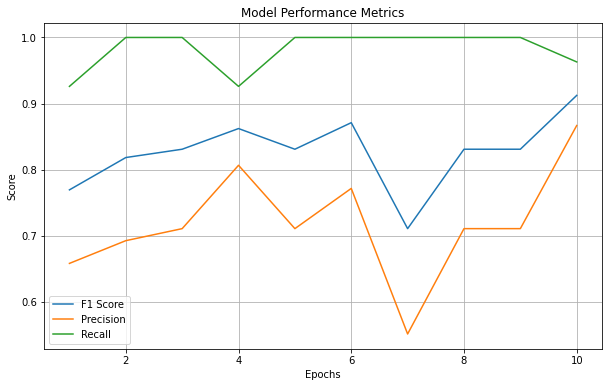

In [56]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[f1_callback, early_stopping, model_checkpoint_callback],
    class_weight=class_weight_dict,  # 클래스 가중치 사용
    verbose=2
)

# 학습 완료 후 지표 플로팅
f1_callback.plot_metrics()


In [57]:
# 모델 예측
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# 양성으로 예측된 샘플의 원본 인덱스와 예측된 레이블 추출
positive_indices = np.where(predicted_labels == 1)[0]
positive_actual_indices = indices_test[positive_indices]
positive_predicted_labels = predicted_labels[positive_indices]

# 원본 데이터에서 해당 인덱스의 'ticker'와 실제 레이블 추출
if 'ticker' in df.columns:
    positive_tickers = df.loc[positive_actual_indices, 'ticker']
else:
    positive_tickers = ["Unknown Ticker"] * len(positive_actual_indices)  # ticker 컬럼이 없는 경우 처리

actual_labels = y_test[positive_indices]  # y_test에서 양성으로 예측된 인덱스의 실제 레이블 추출

# 결과 출력
for idx, ticker, pred_label, act_label in zip(positive_actual_indices, positive_tickers, positive_predicted_labels, actual_labels):
    print(f"Original Index: {idx}, Ticker: {ticker}, Predicted: {pred_label}, Actual: {act_label}")

Original Index: 714, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 380, Ticker: 005930, Predicted: [1], Actual: 0
Original Index: 266, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 850, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 858, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 67, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 836, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 265, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 846, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 260, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 66, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 856, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 705, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 63, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 65, Ticker: 005930, Predicted: [1], Actual: 1
Original Index: 286, Ticker: 005930, Predicted: [1], Actual